In [1]:
# main_two_phase.py
"""Main script demonstrating two-phase electromagnetic PINN training"""

import os
# Set GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = '0'


import jax
from jax import random

# Import utils modules
from utils import (
    CONFIG, init_mlp_params, print_config_summary, print_model_info,
    save_model, load_model, get_domain_info,
    initialize_networks, 
    visualize_permittivity, visualize_points_distribution, 
    run_two_phase_training, 
    net_with_bc, net_with_bc_phase2,
    visualize_solution, visualize_solution_phase2
)


Two-Phase Electromagnetic PINN Simulation
Configuration Summary:
Domain: (-3.5, 3.5) x (-3.5, 3.5)
Interior: (-3.0, 3.0) x (-3.0, 3.0)
PML thickness: 0.5
Source position: [0.0, 0.5]
Frequency (ω): 25
Network architecture: [2, 256, 256, 256, 1]
Training epochs: 20000
Learning rate: 0.0001

Domain Information:
Extended domain area: 49.00
Interior domain area: 36.00
PML coverage: 26.5%

Initializing SIREN networks...
Model Information:
------------------------------
Number of parameter sets: 2 (real and imaginary)
Real network layers: 4
Imaginary network layers: 4
Layer 1: (2, 256) weights + (256,) biases (×2 networks)
Layer 2: (256, 256) weights + (256,) biases (×2 networks)
Layer 3: (256, 256) weights + (256,) biases (×2 networks)
Layer 4: (256, 1) weights + (1,) biases (×2 networks)
Total parameters: 265,218

Visualizing problem setup...
Model loaded from models/circle_level_set_model.pkl


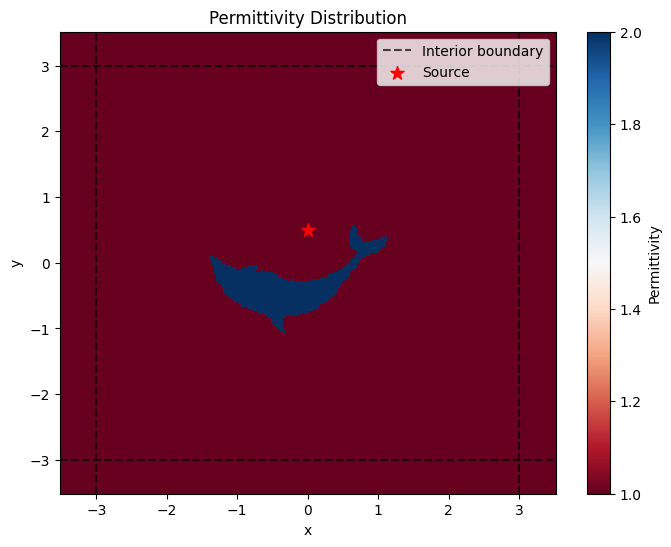

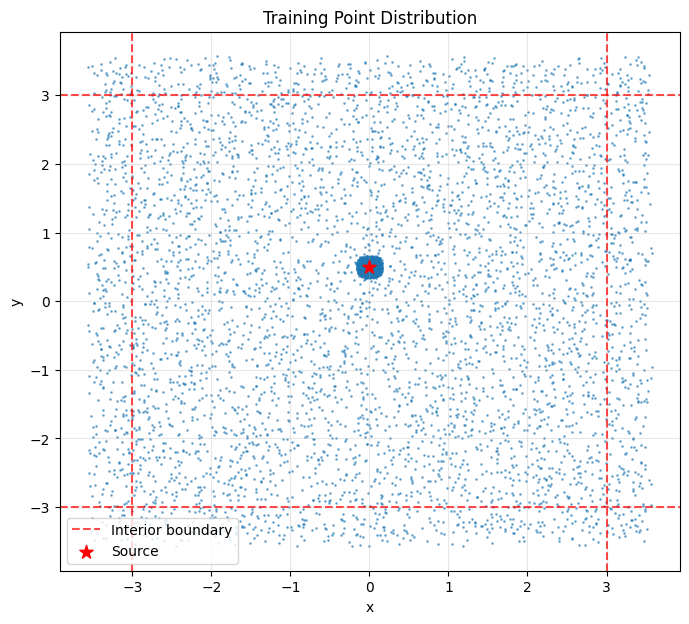

Generated 10000 training points

Starting Two-Phase Training...
TWO-PHASE ELECTROMAGNETIC PINN TRAINING
PHASE 1: Initial Training
Starting Electromagnetic PINN training with PML framework...
Equation: (-∇² - εω²) Ez = -iω Jz
Interior domain: (-3.0, 3.0) x (-3.0, 3.0)
Extended domain: (-3.5, 3.5) x (-3.5, 3.5)
PML parameters: a0=5, Lpml=0.5
Gaussian current source Jz at: [0.0, 0.5] with σ² = 0.0001
Learning rate: 0.0001 with 1000 warmup steps
Gradient clipping: max_norm = 1.0

Theory: In interior A=B=C=1 (standard EM wave equation)
        In PML A,B,C are complex (absorbing layers)

Model loaded from models/circle_level_set_model.pkl
Epoch 0: Total Loss = 5.780398e+01  EM PDE Loss = 5.780334e+01  LR = 0.00e+00  GradNorm = 2601.7739
Epoch 100: Total Loss = 4.020082e+01  EM PDE Loss = 4.006810e+01  LR = 1.00e-05  GradNorm = 1482.7028
Epoch 200: Total Loss = 3.274545e+01  EM PDE Loss = 3.203367e+01  LR = 2.00e-05  GradNorm = 1835.8517
Epoch 300: Total Loss = 8.663668e+00  EM PDE Loss = 8.

In [ ]:

"""Main two-phase training and visualization pipeline"""
print("Two-Phase Electromagnetic PINN Simulation")
print("=" * 60)

# Print configuration summary
print_config_summary()

# Print domain information
domain_info = get_domain_info()
print(f"\nDomain Information:")
print(f"Extended domain area: {domain_info['extended_domain']['area']:.2f}")
print(f"Interior domain area: {domain_info['interior_domain']['area']:.2f}")
print(f"PML coverage: {(1 - domain_info['interior_domain']['area']/domain_info['extended_domain']['area'])*100:.1f}%")

# Initialize random key
rng = random.PRNGKey(42)

# Initialize networks
print("\nInitializing SIREN networks...")
params_initial = initialize_networks(rng)
print_model_info(params_initial)

# Visualize setup
print("\nVisualizing problem setup...")
visualize_permittivity()
pts = visualize_points_distribution()
print(f"Generated {pts.shape[0]} training points")

# Run two-phase training
print("\nStarting Two-Phase Training...")
params_phase1, params_phase2, history_phase1, history_phase2 = run_two_phase_training(params_initial)

# Save both phases
print("\nSaving trained models...")
save_model(params_phase1, "models/trained_em_pinn_phase1.pkl")
save_model(params_phase2, "models/trained_em_pinn_phase2.pkl")

# Plotting results

Model loaded from models/trained_em_pinn_phase1.pkl
Model loaded from models/trained_em_pinn_phase2.pkl
Model loaded from models/circle_level_set_model.pkl


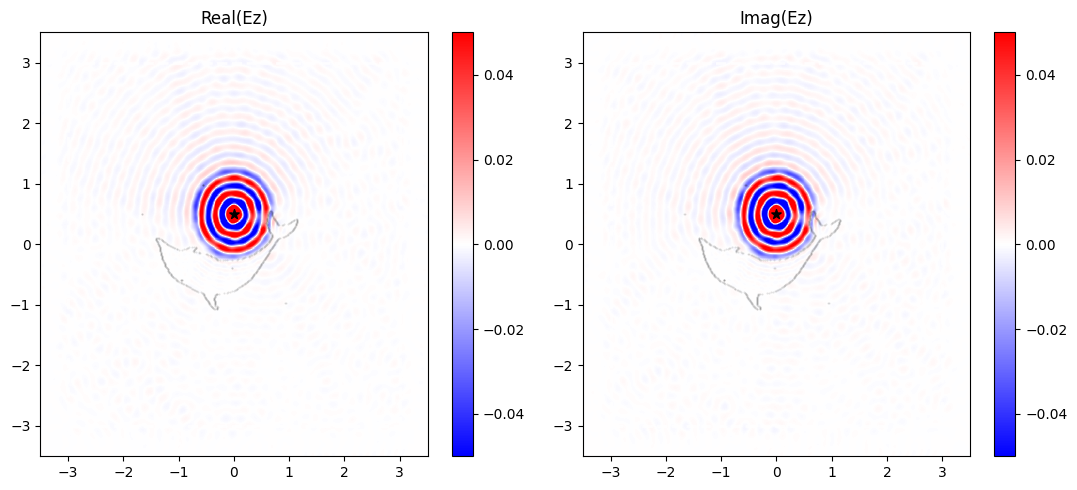

Model loaded from models/circle_level_set_model.pkl


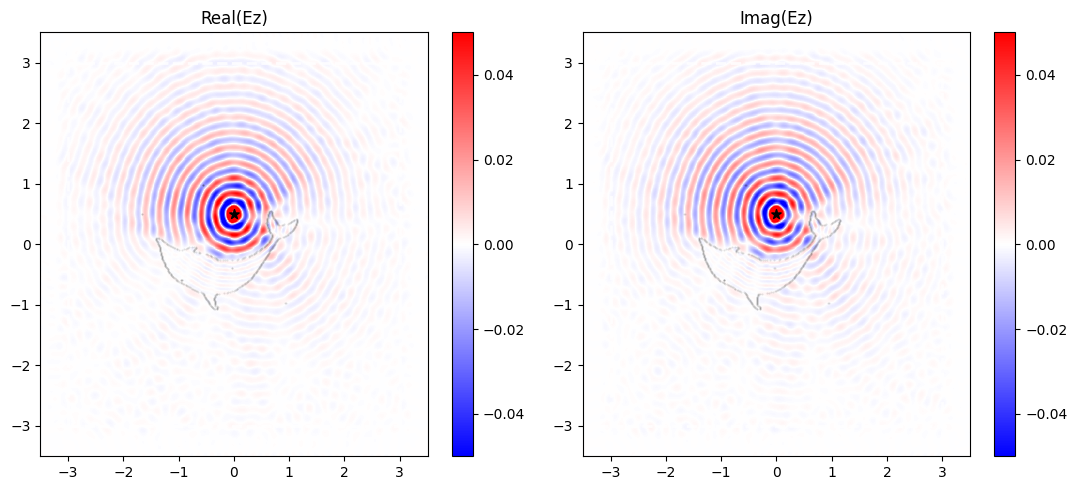

In [ ]:
params_phase1 = load_model("models/trained_em_pinn_phase1.pkl")
params_phase2 = load_model("models/trained_em_pinn_phase2.pkl")

nx = 800
visualize_solution(params_phase1, nx=nx)
visualize_solution_phase2(params_phase2, params_phase1, nx=nx)

# Generate results

Model loaded from models/circle_level_set_model.pkl
Model loaded from models/trained_em_pinn_phase1.pkl
Model loaded from models/trained_em_pinn_phase2.pkl
Model loaded from models/circle_level_set_model.pkl


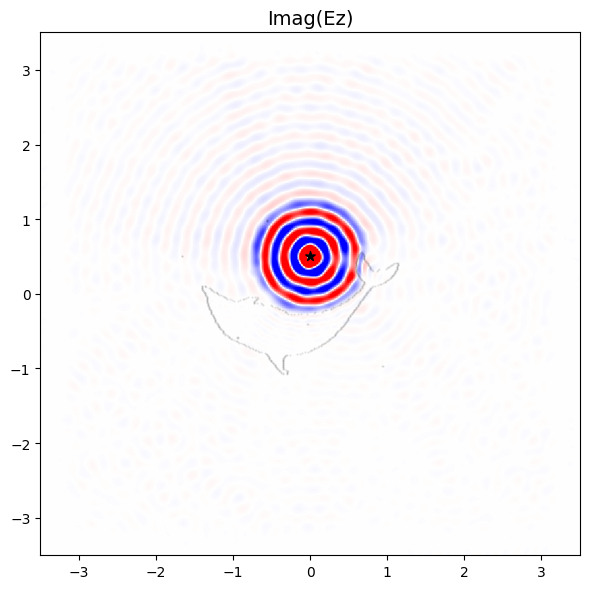

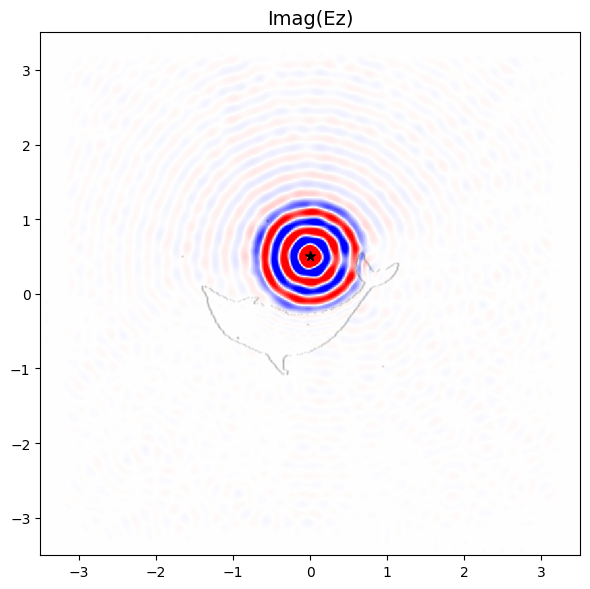

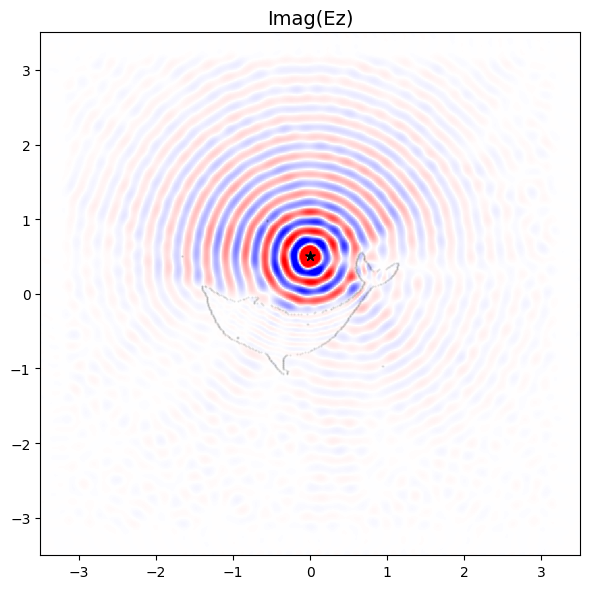

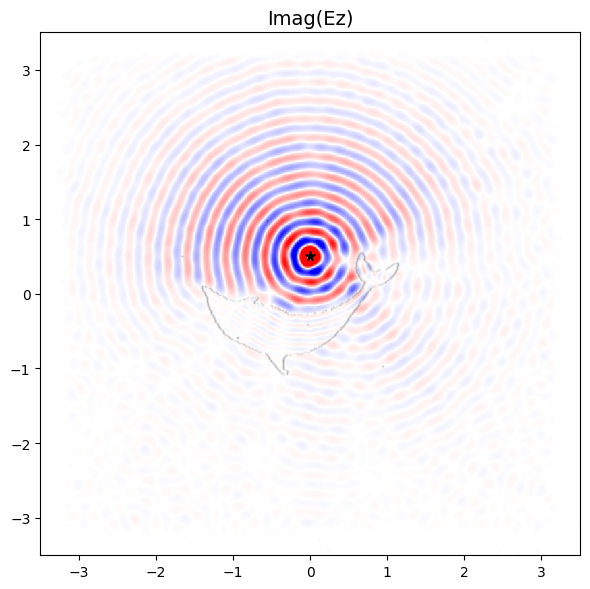

In [18]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import vmap
from utils import *
from utils.permitivity_level_set import LevelSetSIREN

# Load the model (you might want to cache this)
loaded_model = LevelSetSIREN.from_file(CONFIG.paths.level_set_model)

# Load model parameters
params_phase1 = load_model("models/trained_em_pinn_phase1.pkl")
params_phase2 = load_model("models/trained_em_pinn_phase2.pkl")

nx = 800
# Create coordinate grid
x_plot = jnp.linspace(CONFIG.domain.extended_x[0], CONFIG.domain.extended_x[1], nx)
y_plot = jnp.linspace(CONFIG.domain.extended_y[0], CONFIG.domain.extended_y[1], nx)
X, Y = jnp.meshgrid(x_plot, y_plot)
points = jnp.stack((X.flatten(), Y.flatten()), axis=1)
q = vmap(epsilon)(points)

# Get network predictions
Ez_complex = vmap(lambda x: net_with_bc(x, params_phase1))(points)
Ez_real_phase1 = Ez_complex[:, 0].reshape((nx, nx))
Ez_imag_phase1 = Ez_complex[:, 1].reshape((nx, nx))

Ez_complex = vmap(lambda x: net_with_bc_phase2(x, params_phase2, params_phase1))(points)
Ez_real = Ez_complex[:, 0].reshape((nx, nx))
Ez_imag = Ez_complex[:, 1].reshape((nx, nx))

source_pos = get_source_pos()

# Create the Imaginary Ez plot
plt.figure(figsize=(6, 6))
im2 = plt.pcolormesh(X, Y, Ez_real_phase1, cmap='bwr', shading='auto', vmin=-0.05, vmax=0.05)
plt.scatter(X.flatten()[(q + jnp.roll(q,1))==3], Y.flatten()[(q + jnp.roll(q,1))==3], c='k', s=1, marker='.', alpha=0.1)
plt.title('Imag(Ez)', fontsize=14)
plt.scatter(source_pos[0], source_pos[1], c='black', s=50, marker='*')
# plt.colorbar(im2)
plt.tight_layout()
plt.savefig(f'../../Latex/Figs/task1/ez_real_phase1.png', bbox_inches='tight', dpi=900)
plt.show()

# Create the Imaginary Ez plot
plt.figure(figsize=(6, 6))
im2 = plt.pcolormesh(X, Y, Ez_imag_phase1, cmap='bwr', shading='auto', vmin=-0.05, vmax=0.05)
plt.scatter(X.flatten()[(q + jnp.roll(q,1))==3], Y.flatten()[(q + jnp.roll(q,1))==3], c='k', s=1, marker='.', alpha=0.1)
plt.title('Imag(Ez)', fontsize=14)
plt.scatter(source_pos[0], source_pos[1], c='black', s=50, marker='*')
# plt.colorbar(im2)
plt.tight_layout()
plt.savefig(f'../../Latex/Figs/task1/ez_imag_phase1.png', bbox_inches='tight', dpi=900)
plt.show()

# Create the Imaginary Ez plot
plt.figure(figsize=(6, 6))
im2 = plt.pcolormesh(X, Y, Ez_real, cmap='bwr', shading='auto', vmin=-0.05, vmax=0.05)
plt.scatter(X.flatten()[(q + jnp.roll(q,1))==3], Y.flatten()[(q + jnp.roll(q,1))==3], c='k', s=1, marker='.', alpha=0.1)
plt.title('Imag(Ez)', fontsize=14)
plt.scatter(source_pos[0], source_pos[1], c='black', s=50, marker='*')
# plt.colorbar(im2)
plt.tight_layout()
plt.savefig(f'../../Latex/Figs/task1/ez_real_phase2.png', bbox_inches='tight', dpi=900)
plt.show()

# Create the Imaginary Ez plot
plt.figure(figsize=(6, 6))
im2 = plt.pcolormesh(X, Y, Ez_imag, cmap='bwr', shading='auto', vmin=-0.05, vmax=0.05)
plt.scatter(X.flatten()[(q + jnp.roll(q,1))==3], Y.flatten()[(q + jnp.roll(q,1))==3], c='k', s=1, marker='.', alpha=0.1)
plt.title('Imag(Ez)', fontsize=14)
plt.scatter(source_pos[0], source_pos[1], c='black', s=50, marker='*')
# plt.colorbar(im2)
plt.tight_layout()
plt.savefig(f'../../Latex/Figs/task1/ez_imag_phase2.png', bbox_inches='tight', dpi=900)
plt.show()